In [1]:
import h5py # store big data
import scipy.io as io # scipy input and output
import PIL.Image as Image # read imagem, image processing
import numpy as np
import os
import glob # process the path used in unix
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter #gaussian covolution 
import scipy
import json
from matplotlib import cm as CM #color map
from image import *
from model import CSRNet
import torch
import os.path
%matplotlib inline

In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])) # np.nonzero(gt) return a tuple of two array, the first one is the row index of non zero
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize) # construct the kdtree
    # query kdtree
    distances, locations = tree.query(pts, k=4) # get the four nearest points

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1 #why ignore the nearest point
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = r'./UCF/'

In [4]:
#now generate the ShanghaiA's ground truth
train = os.path.join(root,r'train_data','images')
test = os.path.join(root,r'test_data','images')
path_sets = [train,test]

In [5]:
path_sets

['./UCF/train_data/images', './UCF/test_data/images']

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [7]:
glob.glob(os.path.join(r'./UCF/train_data/images', '*.jpg'))

['./UCF/train_data/images/20.jpg',
 './UCF/train_data/images/6.jpg',
 './UCF/train_data/images/23.jpg',
 './UCF/train_data/images/21.jpg',
 './UCF/train_data/images/33.jpg',
 './UCF/train_data/images/37.jpg',
 './UCF/train_data/images/2.jpg',
 './UCF/train_data/images/18.jpg',
 './UCF/train_data/images/7.jpg',
 './UCF/train_data/images/11.jpg',
 './UCF/train_data/images/9.jpg',
 './UCF/train_data/images/25.jpg',
 './UCF/train_data/images/26.jpg',
 './UCF/train_data/images/8.jpg',
 './UCF/train_data/images/27.jpg',
 './UCF/train_data/images/13.jpg',
 './UCF/train_data/images/28.jpg',
 './UCF/train_data/images/22.jpg',
 './UCF/train_data/images/32.jpg',
 './UCF/train_data/images/12.jpg',
 './UCF/train_data/images/39.jpg',
 './UCF/train_data/images/38.jpg',
 './UCF/train_data/images/15.jpg',
 './UCF/train_data/images/29.jpg',
 './UCF/train_data/images/10.jpg',
 './UCF/train_data/images/34.jpg',
 './UCF/train_data/images/31.jpg',
 './UCF/train_data/images/3.jpg',
 './UCF/train_data/images/

In [8]:
img_path = img_paths[0]
mat = io.loadmat(img_path.replace('.jpg','_ann.mat').replace('images','ground_truth')) #mat is microsoft access table

In [9]:
mat

{'__globals__': ['annPoints'],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov 06 16:49:25 2012',
 '__version__': '1.0',
 'annPoints': array([[447.59153713, 342.38085572],
        [485.78842832, 327.79018215],
        [515.27374784, 326.46375728],
        ...,
        [542.74870466, 133.46893863],
        [546.76943005, 138.77463811],
        [548.10967185, 147.39639976]])}

In [10]:
mat['annPoints'] # my guess is that this is the location of the people
print(len(mat['annPoints']))
img = plt.imread(img_paths[0])

2706


In [11]:
img.shape

(384, 600)

In [12]:
for img_path in img_paths:
    if os.path.isfile(img_path.replace('.jpg','.h5').replace('images','ground_truth')):
        continue
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','_ann.mat').replace('images','ground_truth'))
    img= plt.imread(img_path) #R*C*3 array
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat['annPoints']
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

./UCF/train_data/images/20.jpg
(384, 600)
generate density...
done.


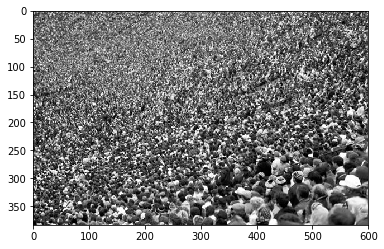

In [13]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

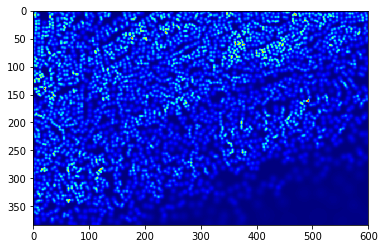

In [14]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [15]:
np.sum(groundtruth)# don't mind this slight variation

2692.7212